# Cassandra
environment setup

* switched to conda mosdef cassandra

`conda create -n cassandra -y -c conda-forge -c mosdef -c omnia 'python=3.7' mbuild foyer openbabel py3dmol pytest jupyterlab mosdef_cassandra`

pip installed gmso

`conda activate cassandra`

Following example based on:

Song, M. K., & No, K. T. (2009). Grand Canonical Monte Carlo simulations of hydrogen adsorption on aluminophosphate molecular sieves. International Journal of Hydrogen Energy, 34(5), 2325–2328. https://doi.org/10.1016/j.ijhydene.2008.12.076

VPI-5 framework structure taken from https://america.iza-structure.org/IZA-SC/mat_cif.php?ID=VFI_0, oxygen atoms removed from pore by deleting atoms in cif file labeled H2O#. Made into a super-cell on Vesta. Then converted to orthorhombic cell shown below.

Does Cassandra use periodic boundary conditions?

In [ ]:
%%bash
# Add Cassandra to your path -- running this cell won't work just copy and paste command
export PATH=/Users/$(whoami)/Projects/Cassandra_V1.2/bin:${PATH}

In [ ]:
# Probably a bad idea, but also there are way too many warnings :/
import warnings

warnings.simplefilter("ignore")

In [2]:
import mosdef_cassandra as mc
#import gmso
import foyer
import mbuild as mb
import mosdef_cassandra.examples as ex
import numpy as np
#from mbuild.lib.recipes.tiled_compound import TiledCompound

In [3]:
# If this fails, you need to add Cassandra to your path
mc.utils.detect_cassandra_binaries();

Using the following executables for Cassandra:
Python: /Users/jenny/miniconda3/envs/cassandra/bin/python
library_setup: /Users/jenny/miniconda3/envs/cassandra/bin/library_setup.py
Cassandra: /Users/jenny/miniconda3/envs/cassandra/bin/cassandra.exe


In [4]:
cif_file = "VPI-5.cif"
with open(cif_file, "r") as f:
    data = [line for line in f.readlines() if not (line.isspace() or line[0] == "#")]
#print(data.index(' loop_\n'))
cell_dict = {}
for line in data:
    if line.startswith("_cell"):
        label = line.split()[0][6:]
        try:
            value = float(line.split()[1])
        except ValueError:
            value = line.split()[1]
        if label.startswith("angle"):
            cell_dict[label] = np.deg2rad(value)
        else:
            cell_dict[label] = value
#print(cell_dict)

atom_lines = data[data.index(' loop_\n')+1:]
atom_labels = [line[11:].strip("\n") for line in atom_lines if line.startswith("_")]
atoms = []
for line in atom_lines[len(atom_labels):]:
    line_split = line.split()
    atom_dict = {}
    for label, item in zip(atom_labels,line_split):
        try:
            item = float(item)
        except ValueError:
            pass
        atom_dict[label] = item
    atoms.append(atom_dict)
#print(atom_dict)

In [7]:
#pop_inds = [i for i,atom in enumerate(atoms) if atom["label"].startswith("H2O")]
#for ind in pop_inds[::-1]:
#    atoms.pop(ind)

#pos_fract = np.empty((len(atoms),3))
#names = []
#for i,atom in enumerate(atoms):
#    names.append(atom["type_symbol"])
#    pos_fract[i,:] = [atom["fract_x"],atom["fract_y"],atom["fract_z"]]
#    
#print(names, pos_fract)

In [6]:
#print(cell_dict)
a = np.array([cell_dict["length_a"], 0, 0])

b = np.array([
    cell_dict["length_b"]*np.cos(cell_dict["angle_gamma"]),
    cell_dict["length_b"]*np.sin(cell_dict["angle_gamma"]),
    0
])

inside = (
    np.cos(cell_dict["angle_alpha"])-np.cos(cell_dict["angle_beta"])*np.cos(cell_dict["angle_gamma"])
)/np.sin(cell_dict["angle_gamma"])

c = np.array([
    cell_dict["length_c"]*np.cos(cell_dict["angle_beta"]),
    cell_dict["length_c"]*inside,
    cell_dict["length_c"]*np.sqrt(
        1-np.cos(cell_dict["angle_beta"])**2-inside**2
    ),
])

lattice = np.stack((a,b,c))
lattice

#print(pos_fract[0])
#lattice.T.dot(pos_fract[0])

array([[ 1.89752000e+01,  0.00000000e+00,  0.00000000e+00],
       [-9.48760000e+00,  1.64330052e+01,  0.00000000e+00],
       [ 4.96251376e-16,  8.59532596e-16,  8.10440000e+00]])

Next we can make a cubic unit cell like this:

![img](VPI-5.png)

In [7]:
## Convert fractional positions to cartesian
#pos_cart = lattice.T.dot(pos_fract.T).T/10
#pos_cart[0]

#crystal = mb.Compound()
#for name, xyz in zip(names,pos_cart):
#    crystal.add(mb.Particle(name = name, pos = xyz))


# Supercell made in vesta VPI-5.cif repeating (x [0,3] and y [0,2])
# in the "boundary" option and saving as xyz
# lengths in nm
l_right=np.array([0,0,0])
l_left=2*a/10
u_right=(2*b+a)/10
u_left=(2*b+3*a)/10


cart_crystal = mb.load("VPI-5_3x2.xyz")
cart_crystal.add(mb.Particle(name="Cl", pos=l_right))
cart_crystal.add(mb.Particle(name="Cl", pos=l_left))
cart_crystal.add(mb.Particle(name="Cl", pos=u_right))
cart_crystal.add(mb.Particle(name="Cl", pos=u_left))
cart_crystal.visualize().show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [8]:
#print(lower_bound_x,upper_bound_x,lower_bound_y,upper_bound_y)

lower_bound_x = l_right[0]
upper_bound_x = l_left[0]
lower_bound_y = l_left[1]
upper_bound_y = u_left[1]

for p in cart_crystal.particles():
    if not (lower_bound_x <= p.pos[0] < upper_bound_x):
        cart_crystal.remove(p)
    elif not (lower_bound_y <= p.pos[1] < upper_bound_y):
        cart_crystal.remove(p)
    elif p.name == "Cl":
        cart_crystal.remove(p)

In [9]:
box = mb.Box(
    mins=[lower_bound_x, lower_bound_y, cart_crystal.boundingbox.mins[2]],
    maxs=[upper_bound_x, upper_bound_y, cart_crystal.boundingbox.maxs[2]],
)

In [68]:
def make_supercell(compound, box, repeat):
    supercell = mb.Compound()
    repx, repy, repz = repeat
    shifts = box.maxs - box.mins
    for rx in range(repx):
        for ry in range(repy):
            for rz in range(repz):
                tvec = shifts*np.array([rx,ry,rz])
                tcomp = mb.clone(compound)
                tcomp.translate(tvec)
                supercell.add(tcomp)
    return supercell

supercell = make_supercell(cart_crystal, box, (3,3,1))

supercell.visualize().show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [11]:
# in order to infer the bonds outside of the cell -- we'll make a supercell 
# and delete everything but the center cell


#cart_crystal.periodicity = [1,1,0]
#cart_supercell = TiledCompound(cart_crystal, (2,2,1))
# ^^^ this didn't work the way I thought it should...

#cart_supercell.visualize().show()

In [69]:
# This takes over a minute.
typeset = set([p.name for p in supercell.particles()])
for i in typeset:
    for j in typeset:
        supercell.generate_bonds(i,j,0,0.2)

In [13]:
supercell.visualize().show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [72]:
# this should be how to create a surface with a vacuum above it
supercell.periodicity = supercell.boundingbox.lengths + np.array([0,0,10])
supercell.periodicity

array([11.3376822,  9.8565167, 10.8525829])

In [73]:
# In order to specify the units--switch to GMSO
#uff = gmso.ForceField("uff.xml") -- can't apply

uff = foyer.Forcefield()
uff.loadFile("uff-foyer.xml")

In [74]:
typed_zeolite = uff.apply(
    supercell, assert_bond_params=False, assert_angle_params=False, 
    assert_dihedral_params=False
)

/Users/jenny/miniconda3/envs/cassandra/lib/python3.7/site-packages/parmed/openmm/topsystem.py:238: OpenMMWarning: Adding what seems to be Urey-Bradley terms before Angles. This is unexpected, but the parameters will all be present in one form or another.
  'all be present in one form or another.', OpenMMWarning)


In [34]:
all_types = set([atom.type for atom in typed_zeolite.atoms])

print(all_types)

# We want to see only P_3+5, O_3_z, and Al3
# but because we're looking at a slice of a periodic structure
# --aka some bonds are missing because they are to atoms in a neighboring cell--
# the parameterization is _almost_ right.
# I think we would need to try repeating the structure, 
# making bonds, typing the middle cell, then deleting the duplicates. 

{'O_2', 'P_3+3', 'O_', 'Al3', 'P_3+5', 'O_3_z', 'P_'}


In [75]:
# let's delete all atoms that don't belong to the center cell
#print(typed_zeolite.atoms[0].xx,typed_zeolite.atoms[0].xy,typed_zeolite.atoms[0].xz)
#p0 = [p.pos for p in supercell.particles()][0]
#print(p0) # compound pos x 10 = structure pos

boxvec = (box.maxs-box.mins) * np.array([1,1,0])
lowerbound = (box.mins + boxvec) * 10
upperbound = (box.maxs + boxvec) * 10
#print(upperbound,lowerbound)
i = 0
remove = np.zeros([supercell.n_particles])
for atom in typed_zeolite.atoms:
    pos = np.array([atom.xx, atom.xy, atom.xz])
    if np.any(pos > upperbound) or np.any(pos < lowerbound):
        remove[atom.idx] = 1
    else:
        i+=1
if i == supercell.n_particles/9:
    print("center cell has correct number of particles")

center cell has correct number of particles


In [76]:
typed_zeolite.strip(remove)

In [54]:
#typed_comp = mb.Compound()
#typed_comp.from_parmed(typed_zeolite)
#typed_comp.visualize().show()

In [55]:
# now the typed_zeolite should have all the correct types
all_types =[atom.type for atom in typed_zeolite.atoms]

print(set(all_types))

# We want to see only P_3+5, O_3_z, and Al3
# -- it still doesn't work

{'Al3', 'O_2', 'O_3_z', 'P_3+5'}


In [77]:
# but we can jsut hack it for now
for atom in typed_zeolite.atoms:
    if atom.type == "O_2":
        atom.type = "O_3_z"

In [78]:
# also remove all bonds
for b in typed_zeolite.bonds:
    try:
        b.delete()
    except AttributeError:
        pass
typed_zeolite.prune_empty_terms()
#typed_zeolite.bonds = None

In [79]:
typed_comp = mb.Compound()
typed_comp.from_parmed(typed_zeolite)
typed_comp.visualize().show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [91]:
hydrogen = mb.Compound()
hydrogen.add(mb.Particle(name="H", pos=np.array([0,0,0])))
hydrogen.add(mb.Particle(name="H", pos=np.array([0,0.073,0]))) # H2 bond is 0.74 A or 0.074 nm
hydrogen.add_bond((hydrogen[0],hydrogen[1]))
hydrogen.visualize().show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [93]:
%%bash
# Delete output of previous run
rm -rf *.in.* species* *.out* *.inp* *.log

In [94]:
# OK in the song paper they use UFF and Burchart FF, 
# but I'm going to use just UFF for the surface and hydrogen


# Use foyer to apply forcefields
typed_hydrogen = uff.apply(
    hydrogen, 
    assert_bond_params=True, 
    assert_angle_params=False, 
    assert_dihedral_params=False
)
# parmed structure is in A-- typed_hydrogen.bonds[0].measure() = 0.74 


# Create box and species list
box_list = [typed_comp]
species_list = [typed_zeolite, typed_hydrogen]

# Since we have an occupied box we need to specify
# the number of each species present in the intial config
mols_in_boxes = [[1, 0]]

system = mc.System(box_list, species_list, mols_in_boxes=mols_in_boxes)
moves = mc.Moves("gcmc", species_list)

custom_args = {
    "chemical_potentials": ["none", -30.0],
    "rcut_min": 0.5,
    "vdw_cutoff": min(box.lengths)/2.1,
    "charge_style": "none",
    #"charge_cutoff": 14.0,
    "coord_freq": 100,
    "prop_freq": 10,
}

mc.run(system, moves, "equilibration", 10000, 300.0, **custom_args)

/Users/jenny/miniconda3/envs/cassandra/lib/python3.7/site-packages/parmed/openmm/topsystem.py:238: OpenMMWarning: Adding what seems to be Urey-Bradley terms before Angles. This is unexpected, but the parameters will all be present in one form or another.
  'all be present in one form or another.', OpenMMWarning)


Treating <Structure 468 atoms; 1 residues; 0 bonds; PBC (orthogonal); NOT parametrized> as a non-insertable rigid species since it has no bonds
Using the following executables for Cassandra:
Python: /Users/jenny/miniconda3/envs/cassandra/bin/python
library_setup: /Users/jenny/miniconda3/envs/cassandra/bin/library_setup.py
Cassandra: /Users/jenny/miniconda3/envs/cassandra/bin/cassandra.exe
Generating fragment libraries...


/Users/jenny/miniconda3/envs/cassandra/lib/python3.7/site-packages/mbuild/formats/cassandramcf.py:178: UserWarning: No bonds found. Cassandra will interpet this as a rigid species
  warnings.warn("No bonds found. Cassandra will interpet "
/Users/jenny/miniconda3/envs/cassandra/lib/python3.7/site-packages/mbuild/formats/cassandramcf.py:564: UserWarning: More than two atoms present but no fragments identified.
  warnings.warn('More than two atoms present but '


Running Cassandra...


I'm using this cell to keep record of the errors I encounter-- most recent at the bottom

```Initial vdw cutoff is greater than half the minimum box length
 28 This error occurred in subroutine Get_Pair_Style on step 0.
 29 Fatal Error. Stopping program.```
- fixed by making the boxlist an empty box with correct size

``` Fixed bond is broken between atoms 1 and 2 of molecule 1 of species 2
 Bond length in MCF:    7.340
 Current bond length:   0.740```
- Looks like there is some conversion between nm and A :/ -- not fixed yet

Mbuild is in nm, using FF.apply() --> the resulting parmed structure is converted to A. The UFF lengths are in A, but somehow the FF params are converted to 10xA in the apply step. How can I specify the FF units?
Chatted with M Thompson, foyer units must be nm--GMSO require explicit units. let's switch to GMSO.

- errrr... GMSO can't be used with cassandra yet because I need the apply function.
 I switched units in foyer FF to nm and set the periodicity of the compound, as advised by Ryan. It seems to work! but now I get a new error:
 
 ```Long-range electrostatics cannot be computed for box 1 due to its net charge
 30 This error occurred in subroutine main.f90 on step 0.```
 
 I think this has to do with changing the unit cell to cubic D: ugh. Can I just turn off electrostatics for now?
 
Fixed by setting charge_style to "none" !! :D `Cassandra simulation complete`!!!!!!!!!!!!

now to see if it is _correct_

In [97]:
%%bash

mkdir song_results
mv -f *.in.* species* *.out* *.inp* *.log song_results

In [1]:
import ex_render_cassandra as erc

In [2]:
# slow!
xyzfile = "song_results/gcmc.out.xyz"
boxfile = "song_results/gcmc.out.H"
traj = erc.make_traj(xyzfile, boxfile)
erc.display_movie(erc.render_sphere_frame, traj, "song.gif")

![](song.gif)

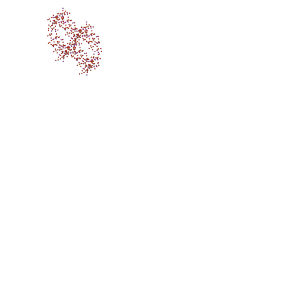

In [13]:
erc.render_sphere_frame(traj[0])

In [14]:
# ok so this is "working" but the trajectory should be centered about the origin